In [4]:
import numpy as np
import pandas as pd
import re
import nltk
#import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#import contractions

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
df_combined = pd.read_csv('/content/augment_ai_df.csv')

df_combined.head(2)

,main_category,text,emotion_intensity
0,sadness,feeling rather rotten ambitious right,0.5
1,sadness,updating blog feel shitty,0.5


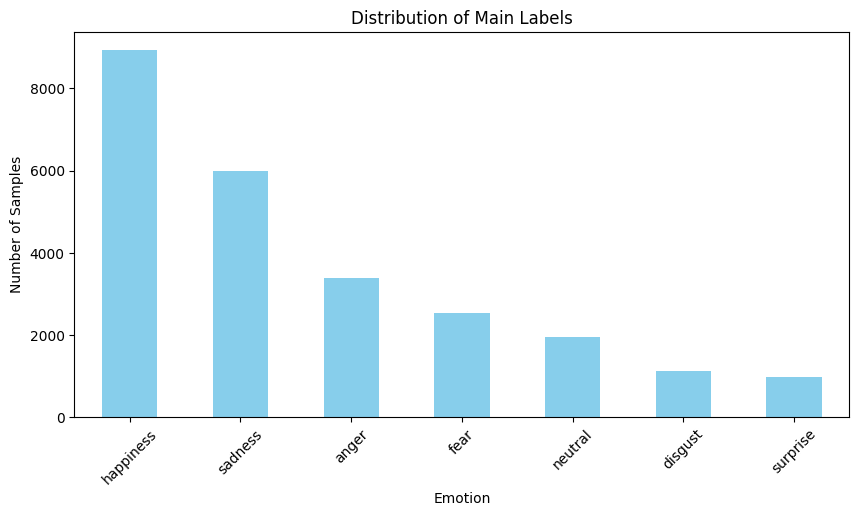

In [7]:
# Count the occurrences of each main_label category
label_counts = df_combined['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [8]:
text_counts = df_combined['text'].value_counts()
print(text_counts.head(20))

text
feel wronged                        5
feel accepted                       5
feel tortured                       4
feel glad                           4
feel scared                         4
feeling pissed                      4
feel overwhelmed                    4
feel troubled                       4
feeling stressed                    4
hate producers completely           3
feeling jaded                       3
feel passionate                     3
feel stressed                       3
feel sad                            3
feeling fine                        3
feel dirty                          3
feel irritated                      3
feeling grouchy                     3
can not accept treatment anymore    3
feel disheartened                   3
Name: count, dtype: int64


In [9]:
import spacy

nlp = spacy.load("en_core_web_sm")
POS_TAGS = ["NOUN", "VERB", "ADJ", "ADV", "PRON", "PROPN", "NUM", "INTJ"]
def get_pos_vector(text):
    doc = nlp(text)
    counts = {tag: 0 for tag in POS_TAGS}
    for token in doc:
        if token.pos_ in POS_TAGS:
            counts[token.pos_] += 1
    return [counts[tag] for tag in POS_TAGS]

pos_features = np.array([get_pos_vector(txt) for txt in df_combined['text']])
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

sentiment_scores = np.array([get_sentiment_score(txt) for txt in df_combined['text']]).reshape(-1, 1)

tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df_combined['text']).toarray()

def get_negation_count(text):
    negations = {"not", "never", "no", "n't"}
    tokens = text.lower().split()
    return sum(1 for t in tokens if t in negations)

negation_counts = np.array([get_negation_count(txt) for txt in df_combined['text']]).reshape(-1, 1)


extra_features = np.hstack([
    pos_features,
    sentiment_scores,

    tfidf_matrix,
    negation_counts
])

print("extra_features shape:", extra_features.shape)

extra_features shape: (24874, 510)


In [10]:
#
df = df_combined.copy()

In [11]:
label_encoder = LabelEncoder()

df['label'] = label_encoder.fit_transform(df['main_category'])
num_classes = df['label'].nunique()
print("Unique Classes:", list(label_encoder.classes_))

texts = df['text'].values
labels = df['label'].values
MAX_LENGTH = 300
OOV_TOKEN = "<OOV>"
tokenizer = Tokenizer(oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab Size:", vocab_size)

padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
y_onehot = to_categorical(labels, num_classes=num_classes)

Unique Classes: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Vocab Size: 17767


In [12]:
X_seq = padded_sequences
X_ext = extra_features

X_seq, X_test_seq, X_ext, X_test_ext, y_train, y_test = train_test_split(
    X_seq, X_ext, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)
X_seq, X_val_seq, X_ext, X_val_ext, y_train, y_val = train_test_split(
    X_seq, X_ext, y_train, test_size=0.1, random_state=42, stratify=y_train
)
print("Train seq shape:", X_seq.shape, "Train ext shape:", X_ext.shape)
print("Val seq shape:", X_val_seq.shape, "Val ext shape:", X_val_ext.shape)
print("Test seq shape:", X_test_seq.shape, "Test ext shape:", X_test_ext.shape)


Train seq shape: (17909, 300) Train ext shape: (17909, 510)
Val seq shape: (1990, 300) Val ext shape: (1990, 510)
Test seq shape: (4975, 300) Test ext shape: (4975, 510)


In [14]:
EMBEDDING_DIM = 300
embedding_index = {}
glove_path = "/content/glove.6B.300d.txt"
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for w, i in word_index.items():
    if w in embedding_index:
        embedding_matrix[i] = embedding_index[w]
nonzero_rows = np.count_nonzero(np.sum(embedding_matrix, axis=1))
print("Non-zero Embeddings:", nonzero_rows, "/", vocab_size)

Non-zero Embeddings: 16068 / 17767


In [15]:
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred, 'float'), axis=0)
    actual_positives = K.sum(K.cast(y_true, 'float'), axis=0)
    precision = tp / (predicted_positives + K.epsilon())
    recall = tp / (actual_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Sequence branch
sequence_input = Input(shape=(MAX_LENGTH,), name="sequence_input")
x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=output)

model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', f1_metric]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)          │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 300, 300)            │       5,330,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300, 128)            │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 300, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,563,579 (21.22 MB)

 Trainable params: 5,563,195 (21.22 MB)

 Non-trainable params: 384 (1.50 KB)

In [16]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 201s 343ms/step - accuracy: 0.2175 - f1_metric: 0.0314 - loss: 2.0410 - val_accuracy: 0.4829 - val_f1_metric: 0.0657 - val_loss: 1.4300 - learning_rate: 1.0000e-04
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 184s 328ms/step - accuracy: 0.4763 - f1_metric: 0.1637 - loss: 1.4230 - val_accuracy: 0.5623 - val_f1_metric: 0.2492 - val_loss: 1.2355 - learning_rate: 1.0000e-04
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 181s 323ms/step - accuracy: 0.5836 - f1_metric: 0.2964 - loss: 1.1843 - val_accuracy: 0.6759 - val_f1_metric: 0.4002 - val_loss: 0.9984 - learning_rate: 1.0000e-04
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 181s 324ms/step - accuracy: 0.6699 - f1_metric: 0.3982 - loss: 0.9819 - val_accuracy: 0.6809 - val_f1_metric: 0.4658 - val_loss: 0.9945 - learning_rate: 1.0000e-04
Epoch 5/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 186s 332ms/step - accuracy: 0.7289 - f1_metric: 0.4916 - loss: 0.8150 - val_accuracy: 0.7965 - val_f1_metric: 0.6050 - val_loss: 0.6631 - learni

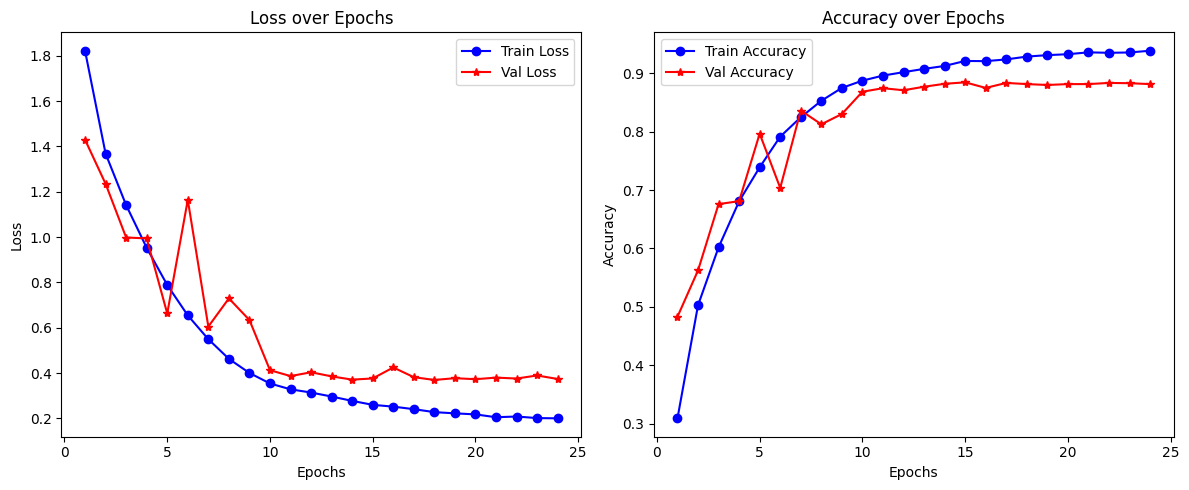

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, 'b-o', label="Train Loss")
plt.plot(epochs_range, val_loss, 'r-*', label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, 'b-o', label="Train Accuracy")
plt.plot(epochs_range, val_acc, 'r-*', label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
y_test_probs = model.predict(X_test_seq)
y_test_pred = np.argmax(y_test_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))

156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.90      0.88       677
     disgust       0.90      0.93      0.91       225
        fear       0.84      0.76      0.80       505
   happiness       0.96      0.92      0.94      1786
     neutral       0.63      0.87      0.73       390
     sadness       0.92      0.90      0.91      1197
    surprise       0.68      0.53      0.60       195

    accuracy                           0.88      4975
   macro avg       0.83      0.83      0.82      4975
weighted avg       0.88      0.88      0.88      4975



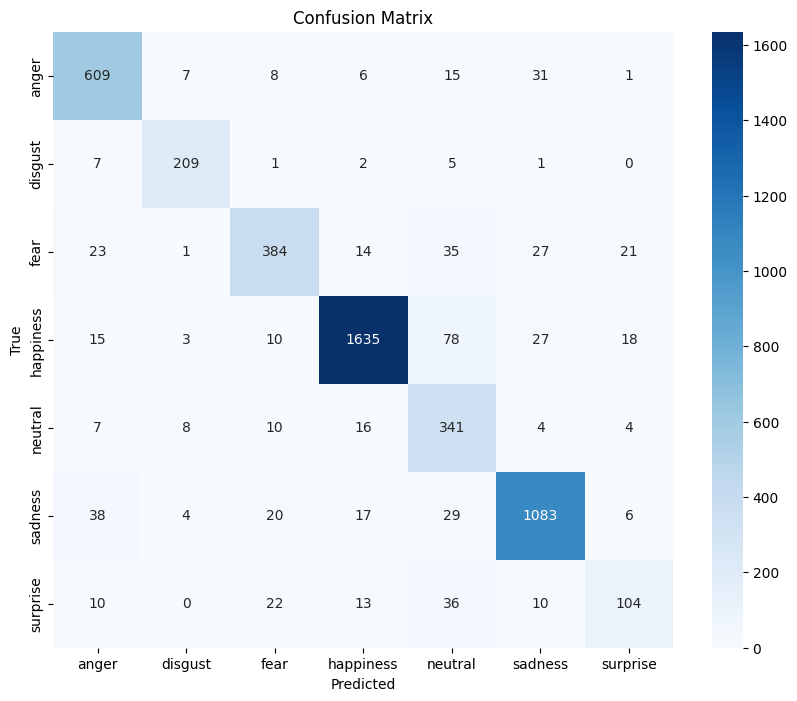

In [19]:
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

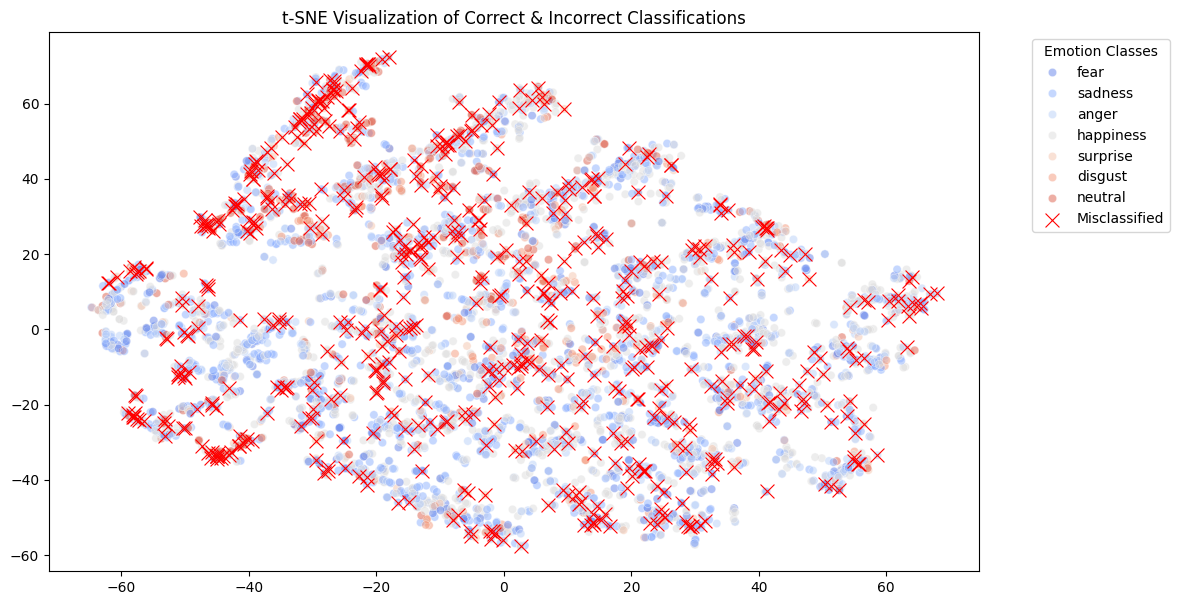

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert embeddings to 2D space using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_test_embedded = tsne.fit_transform(X_test_seq)

# Get true and predicted labels
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(y_test_probs, axis=1)

# Identify misclassified points
incorrect_idxs = np.where(y_test_true != y_test_pred)[0]

# Convert numeric labels to class names
class_labels = label_encoder.classes_  # Extract emotion names
y_test_labels = [class_labels[i] for i in y_test_true]  # True labels as text

plt.figure(figsize=(12, 7))

# Plot correct classifications with actual class names
sns.scatterplot(x=X_test_embedded[:, 0], y=X_test_embedded[:, 1],
                hue=y_test_labels, palette='coolwarm', alpha=0.5, legend=True)

# Overlay misclassified points with red crosses
sns.scatterplot(x=X_test_embedded[incorrect_idxs, 0], y=X_test_embedded[incorrect_idxs, 1],
                color='red', marker="x", s=100, label="Misclassified")

plt.title("t-SNE Visualization of Correct & Incorrect Classifications")
plt.legend(title="Emotion Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Better legend placement
plt.show()


In [21]:
# Extract misclassified examples
misclassified_indices = incorrect_idxs[:100]  # Show first 10 misclassified sentences

print("Misclassified Sentences:")
for i in misclassified_indices:
    true_label = label_encoder.inverse_transform([y_test_true[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_test_pred[i]])[0]

    print(f"Text: {df_combined.iloc[i]['text']}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 100)


Misclassified Sentences:
Text: like breathless feeling reader eager see happen next
True Label: surprise
Predicted Label: fear
----------------------------------------------------------------------------------------------------
Text: feel beautifully emotional knowing women knew handful holding baba journey
True Label: happiness
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: sure feeling loss ever go away may dull sweet feeling nostalgia shared life dad luck dad years
True Label: anger
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: hate feel fearful absolutely reason
True Label: happiness
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: feel insecure sometimes
True Label: anger
Predicted Label: sadness
-----------------------------------

In [22]:
# save model
model.save('model7.h5')

# Redo

# Results

The model performs well at 88% accuracy, but it has several problems sutch as:

- **Overfiting  after a few epochs**

Solutions: <br>
Increase dropout in the model<br>
Use L2 regularization<br>
Change data aggmentation method <br>
Change early stopping values <br>

- **Classification Report**<br>
Disgust has an F1-score of 0.99 coild be a problem as most o the data is syntetic<br>
Happiness has a lower recall (0.74) compared to its precision (0.91), suggesting many happiness examples are misclassified<br>
Sadness has lower precision (0.72), meaning many examples labeled as sadness were actually from other categories <br>

Solution:<br>
The model struggles to separate happiness from similar emotions like neutral or surprise. Try other embeding methods<br>
Many examples classified as sadness were actually other emotions (false positives). Adjust class weights <br>

- **Confusion Matrix**

"Happiness" is often confused with "Neutral" and "Sadness"<br>
"Fear" has some confusion with "Sadness" and "Neutral" <br>
"Surprise" is mistaken for "Fear" and vice versa <br>
"Anger" has some confusion with "Fear"<br>

Solution: <br>
Semantic Overlap: Some emotions share common expressions or words (e.g., "I was so excited, I almost cried" could be classified as happiness or sadness).Use context-aware embeddings

- **t-SNE Visualization**

The correct classifications are well-clustered, meaning the model has learned useful patterns. <br>
The misclassified points (red crosses) are scattered across multiple clusters, especially in overlapping emotion spaces.  <br>
This suggests the model struggles with subtle emotional nuances. <br>

Solution:<br>
Use context-aware embeddings<br>
Add more vocabulary <br>
Use context-aware embeddings <br>

- **Misclassified Sentences**
Happiness vs. Neutral/Sadness: Sentences with mild positivity (e.g., “I feel satisfied”) get misclassified as neutral or sadness instead of happiness. <br>
Anger vs. Fear/Sadness: Expressions of frustration or stress sometimes get classified as fear or sadness instead. <br>
Surprise vs. Fear: Sentences with unexpected emotions sometimes get labeled as fear instead of surprise <br>

Solution <br>
Emotion Amplification: Use sentiment intensity features to distinguish between "mild happiness" and "strong happiness."